In [213]:
%load_ext autoreload
%autoreload 2

#Setting Up and Importing the Necessary Packages/Libraries
##Package for reading in Bruker OPUS type files
from brukeropusreader import read_file
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import pathlib
import numpy as np
import pandas as pd
#Local Functions
from hydrogenase_processing.cut_range import cut_range_subtraction, cut_range_subtraction_multiple_wv, cut_range_subtract_multiple_wv
from hydrogenase_processing.second_deriv import second_deriv, first_deriv
from hydrogenase_processing.anchor_points import interact
from hydrogenase_processing.anchor_points import get_peaks, get_start_end_anchorpoints, get_all_anchor_points
from hydrogenase_processing.vaporfit import atm_subtraction
from hydrogenase_processing.vaporfit import AtmFitParams
from scipy.signal import find_peaks, peak_widths
from hydrogenase_processing.anchor_points import get_peaks, get_start_end_anchorpoints, get_all_anchor_points, baseline_spline, get_peaks_absorbance, baseline_correction, get_peak_baseline_absorbance, plot_baseline_data
from hydrogenase_processing.peak_fit import gaussian, peak_fit, lorentzian
from hydrogenase_processing.io import import_run_data


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [214]:
#Paths to Local Data
path_to_water_vapor_data = pathlib.Path("../../data/opus_files/water_vapor")
path_to_output_plots_= pathlib.Path("../../data/output_plots/")
path_to_pD6_data = pathlib.Path("../../data/opus_files/pD6")

In [197]:
pD6_raw_data = import_run_data(path_to_pD6_data)
wv_data = import_run_data(path_to_water_vapor_data)

dict_keys(['Hyd1 pD6 ACT.0000', 'Hyd1 pD6 ACT.0001', 'Hyd1 pD6 ACT.0002', 'Hyd1 pD6 ACT.0003', 'Hyd1 pD6 ACT.0004', 'Hyd1 pD6 ACT.0005', 'Hyd1 pD6 ACT.0006', 'Hyd1 pD6 ACT.0007', 'Hyd1 pD6 ACT.0008', 'Hyd1 pD6 ACT.0009', 'Hyd1 pD6 ACT.0010', 'Hyd1 pD6 ACT.0011', 'Hyd1 pD6 ACT.0012', 'Hyd1 pD6 ACT.0013', 'Hyd1 pD6 ACT.0014', 'Hyd1 pD6 ACT.0015', 'Hyd1 pD6 ACT.0016', 'Hyd1 pD6 ACT.0017', 'Hyd1 pD6 ACT.0018', 'Hyd1 pD6 ACT.0019', 'Hyd1 pD6 ACT.0020', 'Hyd1 pD6 ACT.0021', 'Hyd1 pD6 ACT.0022', 'Hyd1 pD6 ACT.0023', 'Hyd1 pD6 ACT.0024', 'Hyd1 pD6 ACT.0025', 'Hyd1 pD6 OCP.0'])
dict_keys(['WV spectra_empty cell_no window_post_meas.0000', 'WV_empty refl cell_no window.0000', 'WV_empty refl cell_no window.0001', 'WV_empty refl cell_no window.0002', 'WV_empty refl cell_no window.0003', 'WV_empty refl cell_no window.0004'])


In [198]:
#Initializing dict of post water vapor subtraction spectra
cut_range_sub_wv_data = cut_range_subtract_multiple_wv(pD6_raw_data, wv_data, range_start = 2150, range_end = 1850)


WV spectra_empty cell_no window_post_meas.0000
WV_empty refl cell_no window.0000
WV_empty refl cell_no window.0001
WV_empty refl cell_no window.0002
WV_empty refl cell_no window.0003
WV_empty refl cell_no window.0004
2150 1850
959 1115
WV spectra_empty cell_no window_post_meas.0000
WV_empty refl cell_no window.0000
WV_empty refl cell_no window.0001
WV_empty refl cell_no window.0002
WV_empty refl cell_no window.0003
WV_empty refl cell_no window.0004
2150 1850
959 1115
WV spectra_empty cell_no window_post_meas.0000
WV_empty refl cell_no window.0000
WV_empty refl cell_no window.0001
WV_empty refl cell_no window.0002
WV_empty refl cell_no window.0003
WV_empty refl cell_no window.0004
2150 1850
959 1115
WV spectra_empty cell_no window_post_meas.0000
WV_empty refl cell_no window.0000
WV_empty refl cell_no window.0001
WV_empty refl cell_no window.0002
WV_empty refl cell_no window.0003
WV_empty refl cell_no window.0004
2150 1850
959 1115
WV spectra_empty cell_no window_post_meas.0000
WV_empty 

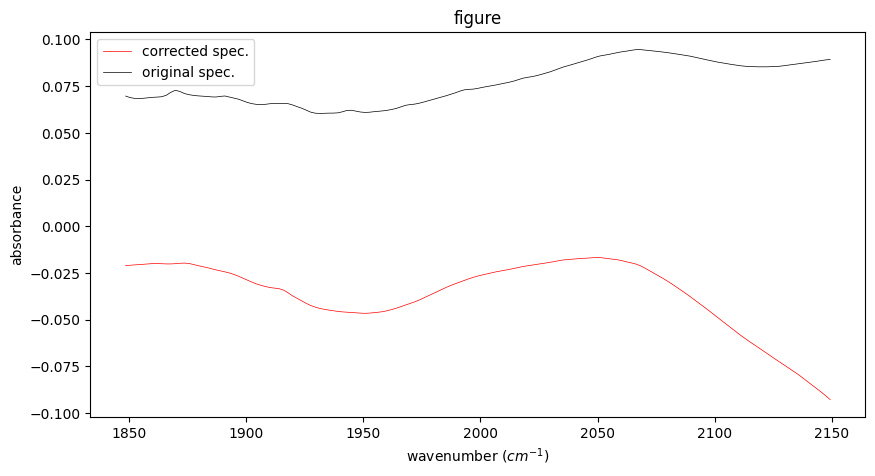

[-2.72325541e-01  3.78516781e+00  2.13659737e-01 -5.28477347e-01
 -3.06131587e+00  6.02276557e-01  2.35995062e-10 -1.00799518e-06
  1.07066827e-03]


In [204]:
sample_raw = cut_range_sub_wv_data["Hyd1 pD6 ACT.0008"]
sample_raw[0][0].plot()

print(sample_raw[0][0].fit_atm_params)

In [200]:
#Creating Empty Dict for second derivative of cut and subtracted data
second_deriv_pD6_data = dict()

#Filling it with second derivatives of all the data
for i in cut_range_sub_wv_data:
    cut_range_sub_wv_data_i = cut_range_sub_wv_data[i]
    print(i)
    second_deriv_pD6_data[f'{i}_second_deriv'] = second_deriv(cut_range_sub_wv_data_i, show_plots=False)

Hyd1 pD6 ACT.0000
Hyd1 pD6 ACT.0001
Hyd1 pD6 ACT.0002
Hyd1 pD6 ACT.0003
Hyd1 pD6 ACT.0004
Hyd1 pD6 ACT.0005
Hyd1 pD6 ACT.0006
Hyd1 pD6 ACT.0007
Hyd1 pD6 ACT.0008
Hyd1 pD6 ACT.0009
Hyd1 pD6 ACT.0010
Hyd1 pD6 ACT.0011
Hyd1 pD6 ACT.0012
Hyd1 pD6 ACT.0013
Hyd1 pD6 ACT.0014
Hyd1 pD6 ACT.0015
Hyd1 pD6 ACT.0016
Hyd1 pD6 ACT.0017
Hyd1 pD6 ACT.0018
Hyd1 pD6 ACT.0019
Hyd1 pD6 ACT.0020
Hyd1 pD6 ACT.0021
Hyd1 pD6 ACT.0022
Hyd1 pD6 ACT.0023
Hyd1 pD6 ACT.0024
Hyd1 pD6 ACT.0025
Hyd1 pD6 OCP.0


In [202]:
sample_second_deriv = second_deriv_pD6_data["Hyd1 pD6 ACT.0008_second_deriv"]
#print(sample_second_deriv)

In [205]:
#anchor_point_dict, deriv_x_peak_val, anchor_points_raw_data, y_corr_abs
anchor_point_dict, deriv_x_peak_val, anchor_points_raw_data, y_corr_abs = interact(sample_second_deriv, sample_raw, 0.4, 1.8)

interactive(children=(BoundedFloatText(value=0.4, description='Threshold for peak selection(0 to 1 in 0.01 steps):', max=1.0, step=0.01), BoundedFloatText(value=1.8, description='adj for anchor point selection(0 to 5 in 0.01 steps):', max=5.0, step=0.01), Output()), _dom_classes=('widget-interact',))


interactive(children=(BoundedFloatText(value=0.4, description='Threshold for peak selection(0 to 1 in 0.01 ste…

In [206]:
peaks_index, deriv_x_peak_val, d2ydx2_peak_val = get_peaks(sample_second_deriv, threshold = 0.4)
wv_startIdx, wv_endIdx = get_start_end_anchorpoints(peaks_index[0], sample_second_deriv)
y_corr_abs = sample_raw[0][0].sub_spectrum
anchor_points_raw_data = sample_raw[0][0].wavenb


In [207]:
anchor_point_dict = {} #key is the adjustment factor and value is the list of anchor points using that adjustemnt factor

anchor_point_dict[2] = get_all_anchor_points(wv_startIdx, wv_endIdx, deriv_x_peak_val, anchor_points_raw_data, y_corr_abs, 2)

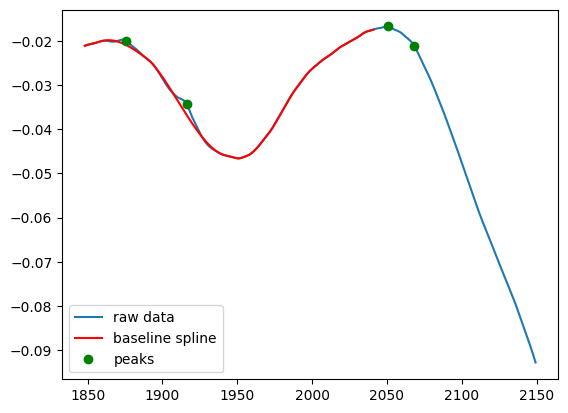

In [208]:
anchor_points = anchor_point_dict.get(2)
anchor_points_df = anchor_points[0]  # Extracting the DataFrame which has the necessary columns because update function takes a data frame of anchor points containing  wavenumber and absorbances
baseline_curve = baseline_spline(anchor_points_df, smooth=10**-9)
peak_wv, peak_abs = get_peaks_absorbance(deriv_x_peak_val, anchor_points_raw_data, y_corr_abs)

plt.plot(anchor_points_raw_data, y_corr_abs, label = 'raw data')
plt.plot(baseline_curve['wavenumber'], baseline_curve['absorbance'], 'r-', label = 'baseline spline')
plt.plot(peak_wv, peak_abs, 'go', label = 'peaks')
plt.legend()


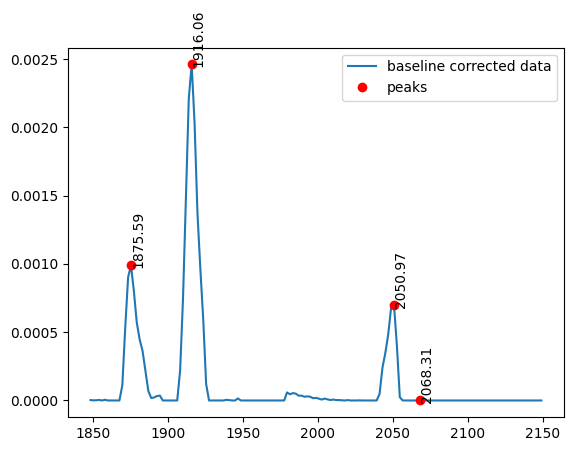

In [209]:
baseline_corrected_abs = baseline_correction(baseline_curve, anchor_points_raw_data, y_corr_abs)
#print(baseline_corrected_abs)
peak_baseline_abs = get_peak_baseline_absorbance(anchor_points_raw_data, baseline_corrected_abs, peak_wv)
plot_baseline_data(anchor_points_raw_data, baseline_corrected_abs, peak_wv, peak_baseline_abs)

In [210]:
#Half height width
indices = np.where(np.isin(anchor_points_raw_data,peak_wv))[0]
peak_width,height, left_ips, right_ips = peak_widths(baseline_corrected_abs, indices, rel_height=0.5) 
print(indices)
print(peak_width)

[ 42  51 121 142]
[0.         4.13531046 4.68621965 4.69767509]


/var/folders/vt/_6rwtq1n0g10kn7_f2s353380000gn/T/ipykernel_59756/2552361210.py:3: PeakPropertyWarning: some peaks have a prominence of 0
  peak_width,height, left_ips, right_ips = peak_widths(baseline_corrected_abs, indices, rel_height=0.5)
/var/folders/vt/_6rwtq1n0g10kn7_f2s353380000gn/T/ipykernel_59756/2552361210.py:3: PeakPropertyWarning: some peaks have a width of 0
  peak_width,height, left_ips, right_ips = peak_widths(baseline_corrected_abs, indices, rel_height=0.5)


In [211]:
def gaussian_fit(x, *params):

    y = np.zeros_like(x)

    for i in range(0, len(params), 3):
        amplitude = params[i]
        center = params[i+1]
        sigma = params[i+2]
        y += amplitude*(1/(sigma* np.sqrt(2*np.pi)))*np.exp((-1/2)*((x - center)/ sigma)**2) 
    return y

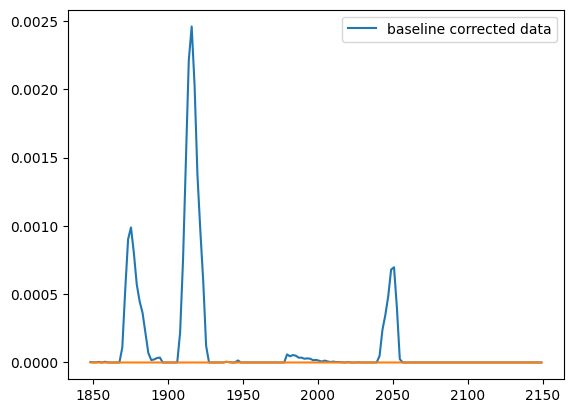

In [212]:
from scipy.optimize import curve_fit
#2091.614748864712, 2080.0497375656423,
guess = [0.3, 1939, 2, 0.14, 1958, 2, 0.014, 2080.05, 2, 0.24, 2091.6, 2]
params, covariance = curve_fit(gaussian_fit, anchor_points_raw_data, baseline_corrected_abs, guess)
plt.plot(anchor_points_raw_data,baseline_corrected_abs, label = 'baseline corrected data')
plt.plot(anchor_points_raw_data, gaussian_fit(anchor_points_raw_data, *params))
plt.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(anchor_points_raw_data,baseline_corrected_abs, 'b', label="given curve")

ax.plot(anchor_points_raw_data, gaussian_fit(anchor_points_raw_data, *params), ls=':', label="Fit function", linewidth=4, color='purple')
for i, (a, c, s )in enumerate( params.reshape(-1, 3)):
    ax.plot(anchor_points_raw_data, gaussian_fit(anchor_points_raw_data, a, c, s), ls='-', label=f"gauss {i+1}", linewidth=1, color='crimson')
ax.legend()
ax.autoscale(axis='x', tight=True)
plt.show()

In [ ]:
guess = [0.3, 1939, 2, 0.14, 1958, 2, 0.014, 2080.05, 2, 0.24, 2091.6, 2]
params = peak_fit(gaussian,guess,  anchor_points_raw_data, baseline_corrected_abs)